# Домашнее задание 5.2

In [1]:
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

from pymorphy3 import MorphAnalyzer

import re
import nltk
from nltk.corpus import stopwords

- guid – UUID (строка),
- title – заголовок,
- description – полный текст статьи,
- published_at – дата/время публикации (строка в ISO-формате),
- comments_count – количество комментариев (есть пропуски),
- created_at_utc – дата/время вставки записи в БД,
- rating – дробное число 0–5.

In [3]:
DB_FILE = "news.db"

# Открываем соединение с SQLite
conn = sqlite3.connect(DB_FILE)

# Читаем всю таблицу articles в DataFrame
df = pd.read_sql_query("SELECT * FROM articles;", conn)

# Закрываем соединение
conn.close()

df

,guid,title,description,url,published_at,comments_count,created_at_utc,rating
0,6581a034-e949-476d-9427-c326a133d3b4,Ученые обнаружили «акценты» у львов из разных ...,Исследователи из Великобритании и Танзании раз...,https://naked-science.ru/article/biology/uchen...,"24 ноября, 20:19",0,2025-11-26T08:01:03.138087,3.5
1,d838c5f4-7072-4d5a-8fea-557b57eeb921,Искусственный интеллект обретает здравомыслие:...,Команда исследователей из МИСиС и МФТИ с колле...,https://naked-science.ru/article/column/iskuss...,"24 ноября, 17:58",0,2025-11-26T08:01:03.140084,4.9
2,3156e749-5ab5-4b83-87f5-24baa453081a,Неандертальцы убили и съели женщин и детей из ...,Анализ неандертальских костей из бельгийской п...,https://naked-science.ru/article/archeology/ne...,"24 ноября, 14:46",0,2025-11-26T08:01:03.140084,3.9
3,fb9fa848-99ab-408c-aff2-efea41f62fbe,"Ученые выяснили, как избежать выгорания студентов",Исследователи Института образования НИУ ВШЭ по...,https://naked-science.ru/article/column/kak-iz...,"24 ноября, 10:59",0,2025-11-26T08:01:03.141080,4.8
4,e56549d4-b130-4e4f-9e46-8e0534a35ef2,"Астрофизики, возможно, нашли следы самых масси...","В далекой галактике, которую ученые видят тако...",https://naked-science.ru/article/astronomy/nas...,"24 ноября, 10:34",0,2025-11-26T08:01:03.142077,5.8
...,...,...,...,...,...,...,...,...
5836,1cfd2b3c-c96a-420f-8925-215f9c9b4349,"Вскрытие мозга долгожителей показало, как обра...",Здоровый образ жизни помогает людям сформирова...,https://naked-science.ru/article/medicine/vskr...,"06.02.2024, 19:54",0,2025-11-27T05:37:11.936457,4.8
5837,de258fd0-54ab-469d-8f10-1cad90c40e29,Заядлые курильщики каннабиса чаще страдали тре...,"Канадские ученые установили, что у 27 проценто...",https://naked-science.ru/article/medicine/zaya...,"06.02.2024, 17:19",0,2025-11-27T05:37:11.936457,4.6
5838,3fc7b66d-c162-406f-ba99-8f5f980f76bd,"Ученые объяснили, почему поведение итальянских...",Исследователи из Великобритании и Италии выясн...,https://naked-science.ru/article/psy/uchi-poho...,"06.02.2024, 16:15",0,2025-11-27T05:37:11.937453,5.2
5839,864b7b51-8ffb-45e3-b361-16ea0818fe5b,Климатологи спрогнозировали сверхсильные урага...,Команда из Национальной лаборатории имени Э. Л...,https://naked-science.ru/article/climate/klima...,"06.02.2024, 14:20",0,2025-11-27T05:37:11.938450,4.1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5841 entries, 0 to 5840
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   guid            5841 non-null   object 
 1   title           5841 non-null   object 
 2   description     5841 non-null   object 
 3   url             5841 non-null   object 
 4   published_at    5841 non-null   object 
 5   comments_count  5841 non-null   int64  
 6   created_at_utc  5841 non-null   object 
 7   rating          5702 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 365.2+ KB


Посмотрим распределение рейтинга и пропусков в comments_count

Пропуски в comments_count: 0
Пропуски в rating: 139


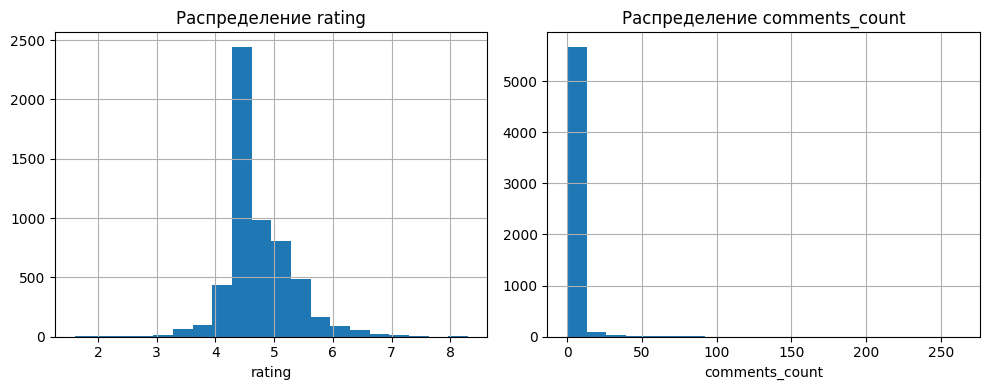

In [5]:
print("Пропуски в comments_count:", df["comments_count"].isna().sum())
print("Пропуски в rating:", df["rating"].isna().sum())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

df["rating"].hist(ax=axes[0], bins=20)
axes[0].set_title("Распределение rating")
axes[0].set_xlabel("rating")

df["comments_count"].hist(ax=axes[1], bins=20)
axes[1].set_title("Распределение comments_count")
axes[1].set_xlabel("comments_count")

plt.tight_layout()
plt.show()

In [6]:
# Скачаем русские стоп-слова NLTK (один раз)
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\margo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Инициализируем морфоанализатор и список стоп-слов
morph = MorphAnalyzer()
RUSSIAN_STOPWORDS = set(stopwords.words("russian"))

# Регулярка для выделения слов (русские и латинские буквы)
TOKEN_RE = re.compile(r"[А-Яа-яA-Za-z]+", flags=re.U)


def preprocess_text(text: str):
    """
    Полная предобработка одного текста:
    - приведение к нижнему регистру,
    - выделение токенов,
    - фильтрация по длине и стоп-словам,
    - лемматизация через pymorphy3.

    Возвращает список лемм (строк).
    """
    if not isinstance(text, str):
        text = "" if text is None else str(text)

    text = text.lower()
    tokens = TOKEN_RE.findall(text)

    lemmas = []
    for token in tokens:
        # Отсекаем короткий мусор
        if len(token) <= 2:
            continue

        # Русские и латинские слова отдельно
        if re.match(r"[а-я]", token):
            # Русское слово: нормальная форма через pymorphy3
            if token in RUSSIAN_STOPWORDS:
                continue
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            if lemma in RUSSIAN_STOPWORDS:
                continue
        else:
            # Латинское/английское слово — оставляем как есть
            lemma = token

        lemmas.append(lemma)

    return lemmas

### Предобработка текста

In [8]:
sample_text = df["description"].iloc[0]
print(sample_text[:100], "...")

preprocess_text(sample_text)[:100]

Исследователи из Великобритании и Танзании разработали метод автоматической классификации львиных во ...


['исследователь',
 'великобритания',
 'танзания',
 'разработать',
 'метод',
 'автоматический',
 'классификация',
 'львиный',
 'вокализация',
 'помощь',
 'машинный',
 'обучение',
 'новый',
 'подход',
 'позволить',
 'уточнить',
 'структура',
 'рёв',
 'выделить',
 'немой',
 'ранее',
 'неизвестный',
 'элемент',
 'повысить',
 'точность',
 'идентификация',
 'отдельный',
 'особь',
 'попутно',
 'выясниться',
 'хищник',
 'разный',
 'регион',
 'африка',
 'разговаривать',
 'разный']

In [10]:
N_DOCS = len(df)

texts = df["description"].iloc[:N_DOCS].tolist()

tokenized_texts = [preprocess_text(t) for t in texts]

# Смотрим пример
tokenized_texts[0][:40]

['исследователь',
 'великобритания',
 'танзания',
 'разработать',
 'метод',
 'автоматический',
 'классификация',
 'львиный',
 'вокализация',
 'помощь',
 'машинный',
 'обучение',
 'новый',
 'подход',
 'позволить',
 'уточнить',
 'структура',
 'рёв',
 'выделить',
 'немой',
 'ранее',
 'неизвестный',
 'элемент',
 'повысить',
 'точность',
 'идентификация',
 'отдельный',
 'особь',
 'попутно',
 'выясниться',
 'хищник',
 'разный',
 'регион',
 'африка',
 'разговаривать',
 'разный']

### Обучение Word2Vec

- vector_size — размерность вектора слова (обычно 100–300). Больше размерность → богаче представление, но, дольше обучать

- window — «окно» контекста (в словах). window=5 означает, что мы смотрим 5 слов слева и справа (до 10 слов контекста).
Большое окно → больше «тематическая» близость; маленькое окно → более синтаксическая.

- min_count — минимальная частота слова, чтобы попасть в словарь. Если min_count=5, все слова, встретившиеся < 5 раз, игнорируются.
Это сильно уменьшает размер словаря и шум от опечаток/редких форм.

- workers — число потоков; влияет только на скорость обучения.
- sg — режим (0 = CBOW, 1 = Skip-gram).
- epochs — сколько «проходов» по корпусу сделать.
Слишком мало — модель «недоучится».
Слишком много — можно начать переобучаться под шум корпуса.

Мы используем:

- vector_size=100 — компромисс между качеством и скоростью.
- window=5 — типичное значение для общего языка.
- min_count=5 — отфильтровываем очень редкие слова.
- sg=1 — Skip-gram, чтобы лучше обрабатывать редкие слова.
- epochs=10 — для небольшого корпуса этого обычно достаточно.

In [11]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences=tokenized_texts,  # список документов, каждый документ = список лемм
    vector_size=120,            # размерность эмбеддинга слова
    window=5,                   # ширина контекста
    min_count=5,                # игнорируем слова реже 5 раз
    workers=4,                  # параллельные потоки
    sg=1,                       # 1 = Skip-gram, 0 = CBOW
    epochs=10,                  # сколько раз пройтись по корпусу
)

w2v_model

In [12]:
w2v_model.wv.most_similar("наука", topn=10)

[('доцент', 0.7943475842475891),
 ('никитин', 0.7887218594551086),
 ('профессор', 0.7854864597320557),
 ('нацимбио', 0.7834149599075317),
 ('холдинг', 0.7803191542625427),
 ('филологический', 0.7792505025863647),
 ('доктор', 0.7755400538444519),
 ('советник', 0.7725423574447632),
 ('игорь', 0.7660397887229919),
 ('ростёха', 0.7649333477020264)]

In [13]:
for test_word in ["наука", "страна", "обучение", "природа", "работа"]:
    if test_word not in w2v_model.wv:
        continue

    print(f"\nПохожие слова для «{test_word}»:")
    for word, score in w2v_model.wv.most_similar(test_word, topn=5):
        print(f"  {word:15s} {score:.3f}")


Похожие слова для «наука»:
  доцент          0.794
  никитин         0.789
  профессор       0.785
  нацимбио        0.783
  холдинг         0.780

Похожие слова для «страна»:
  государство     0.751
  позиция         0.682
  подчёркивать    0.679
  сократиться     0.671
  союз            0.665

Похожие слова для «обучение»:
  машинный        0.905
  обучать         0.855
  языковой        0.852
  классификация   0.851
  нейросетевой    0.844

Похожие слова для «природа»:
  противоречащий  0.742
  дикий           0.738
  приписывать     0.720
  общепринятый    0.711
  устроенный      0.707

Похожие слова для «работа»:
  труд            0.531
  публикация      0.525
  литература      0.509
  достижение      0.504
  утверждать      0.502


Модель успешно улавливает семантические связи, хотя некоторые ассоциации могут быть специфичными для данного набора новостей

## Векторы документов

In [14]:
def document_vector(tokens, model: Word2Vec):
    """
    Строит вектор документа как среднее по векторам слов.
    Слова, которых нет в модели, игнорируются.
    Если нет ни одного слова, выдаём нулевой вектор.
    """
    vectors = [model.wv[token] for token in tokens if token in model.wv]

    if not vectors:
        return np.zeros(model.vector_size, dtype="float32")

    return np.mean(vectors, axis=0)



doc_vectors = np.vstack([document_vector(tokens, w2v_model) for tokens in tokenized_texts])
doc_vectors.shape

(5841, 120)

Каждая статья преобразована в числовой вектор. Размерность: 5841 документ × 120 признаков

In [15]:
doc_vectors[:3]

array([[-0.07146926, -0.06064016,  0.16072921,  0.05867937, -0.08598615,
        -0.03692512,  0.1717444 ,  0.1855917 ,  0.01860763,  0.05662678,
         0.18617378, -0.04884088,  0.22012533, -0.16591887, -0.11689769,
         0.02936718, -0.09027101, -0.05526431, -0.20912695, -0.06170325,
        -0.13170972, -0.14782757,  0.16269733, -0.10664494, -0.06018097,
         0.04478485, -0.14114739,  0.17679355, -0.14700916, -0.13283561,
         0.02391016, -0.29532018,  0.18329936, -0.06756155, -0.0439717 ,
         0.09049574,  0.20338255, -0.33969346, -0.23553222,  0.04509623,
         0.05229035,  0.000506  , -0.17614205, -0.00402301,  0.01780552,
         0.12007234,  0.11658623, -0.02549633, -0.16113625,  0.21924491,
        -0.19212796,  0.0097008 , -0.0300478 ,  0.14208622,  0.07034685,
         0.17042407,  0.00954691,  0.12701555,  0.23196109, -0.15859312,
        -0.00602557,  0.17548968,  0.0120655 ,  0.05672801, -0.07284295,
        -0.00240974,  0.1848634 ,  0.28266758, -0.0

## Снижение размерности через PCA

Для визуализации 120-мерные векторы сжаты до 2 измерений

In [16]:
pca = PCA(n_components=2, random_state=42)

doc_vectors_2d = pca.fit_transform(doc_vectors)
doc_vectors_2d[:5]

array([[-0.19708309, -0.09522184],
       [-0.6682053 , -0.00626178],
       [ 0.5699292 ,  0.24156013],
       [-0.16660234,  0.44083855],
       [ 0.54111546, -0.5449017 ]], dtype=float32)

In [17]:
df_subset = df.iloc[:N_DOCS].copy()
df_subset["pca_x"] = doc_vectors_2d[:, 0]
df_subset["pca_y"] = doc_vectors_2d[:, 1]

df_subset.head()

,guid,title,description,url,published_at,comments_count,created_at_utc,rating,pca_x,pca_y
0,6581a034-e949-476d-9427-c326a133d3b4,Ученые обнаружили «акценты» у львов из разных ...,Исследователи из Великобритании и Танзании раз...,https://naked-science.ru/article/biology/uchen...,"24 ноября, 20:19",0,2025-11-26T08:01:03.138087,3.5,-0.197083,-0.095222
1,d838c5f4-7072-4d5a-8fea-557b57eeb921,Искусственный интеллект обретает здравомыслие:...,Команда исследователей из МИСиС и МФТИ с колле...,https://naked-science.ru/article/column/iskuss...,"24 ноября, 17:58",0,2025-11-26T08:01:03.140084,4.9,-0.668205,-0.006262
2,3156e749-5ab5-4b83-87f5-24baa453081a,Неандертальцы убили и съели женщин и детей из ...,Анализ неандертальских костей из бельгийской п...,https://naked-science.ru/article/archeology/ne...,"24 ноября, 14:46",0,2025-11-26T08:01:03.140084,3.9,0.569929,0.241560
3,fb9fa848-99ab-408c-aff2-efea41f62fbe,"Ученые выяснили, как избежать выгорания студентов",Исследователи Института образования НИУ ВШЭ по...,https://naked-science.ru/article/column/kak-iz...,"24 ноября, 10:59",0,2025-11-26T08:01:03.141080,4.8,-0.166602,0.440839
4,e56549d4-b130-4e4f-9e46-8e0534a35ef2,"Астрофизики, возможно, нашли следы самых масси...","В далекой галактике, которую ученые видят тако...",https://naked-science.ru/article/astronomy/nas...,"24 ноября, 10:34",0,2025-11-26T08:01:03.142077,5.8,0.541115,-0.544902


## Кластеризация документов с помощью DBSCAN

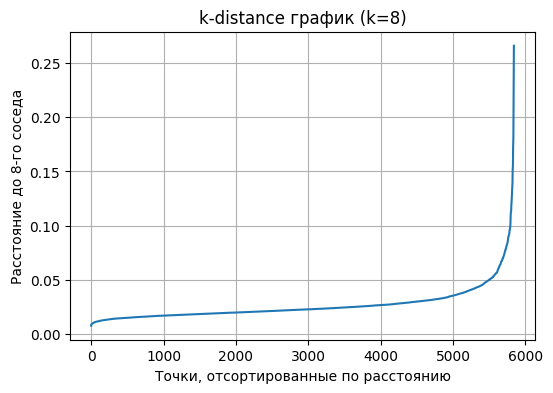

In [18]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

X_for_dbscan = doc_vectors_2d  # или другие признаки
k = 8  # это min_samples

# 1–2. считаем расстояния до k-го соседа
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_for_dbscan)
distances, indices = neigh.kneighbors(X_for_dbscan)

# расстояние до k-го соседа (столбец k-1)
k_distances = np.sort(distances[:, k-1])

# 3–4. строим график
plt.figure(figsize=(6, 4))
plt.plot(k_distances)
plt.title(f"k-distance график (k={k})")
plt.xlabel("Точки, отсортированные по расстоянию")
plt.ylabel(f"Расстояние до {k}-го соседа")
plt.grid(True)
plt.show()

In [19]:
dbscan = DBSCAN(eps=0.03, min_samples=8)


cluster_labels = dbscan.fit_predict(doc_vectors_2d)

# -1 в DBSCAN означает "шум"
np.unique(cluster_labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21]),
 array([ 752, 4771,   31,    9,   33,   28,   41,   37,   12,   18,   12,
           4,   11,   15,   12,    9,   10,    8,    6,    2,    6,    9,
           5]))

23 кластера, шум 13.3%

In [20]:
df_subset["cluster"] = cluster_labels
df_subset[["title", "cluster"]].head(10)

,title,cluster
0,Ученые обнаружили «акценты» у львов из разных ...,0
1,Искусственный интеллект обретает здравомыслие:...,0
2,Неандертальцы убили и съели женщин и детей из ...,-1
3,"Ученые выяснили, как избежать выгорания студентов",0
4,"Астрофизики, возможно, нашли следы самых масси...",0
5,Ученые разработали препарат из клеток человече...,1
6,"Ученые объяснили, почему пауки рода Clubiona н...",0
7,Астрономы нашли редкую быстро растущую сверхма...,-1
8,"Соцсети помогли биологам узнать, на каких насе...",0
9,Геологи раскрыли возможную причину появления т...,-1


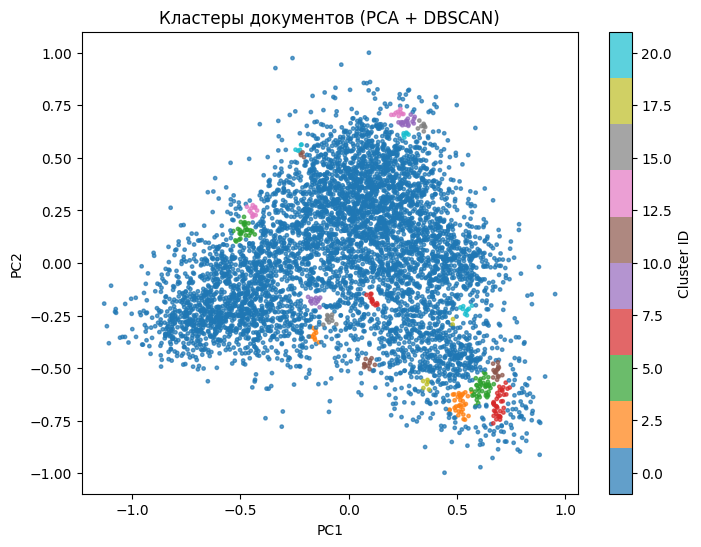

In [21]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_subset["pca_x"],
    df_subset["pca_y"],
    c=df_subset["cluster"],
    s=6,
    cmap="tab10",
    alpha=0.7,
)
plt.colorbar(scatter, label="Cluster ID")
plt.title("Кластеры документов (PCA + DBSCAN)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [22]:
cluster_id = 2

df_subset[df_subset["cluster"] == cluster_id][["title"]].head(10)

,title
35,"Арктическую нефть добыли, не растапливая вечну..."
673,Физики изучили нуклоны с рекордной точностью б...
957,В США начали сборку первого военного микрореак...
1247,"Физики узнали, что три электрона ведут себя ка..."
1906,Химики научились управлять люминесценцией редк...
2132,Кислородные бомбы: в Сколтехе нашли мощную аль...
3102,Физики сделали шаг для понимания фундаментальн...
3275,Термодинамическое моделирование для индуктивно...
4143,"В ИПФ РАН открыли новое физическое явление, св..."


Тут вроде понятно что за кластер, что-то про атомную и квантовую физику в большей части

## Подготовка признаков для supervised-задачи

In [23]:
# Оставляем только объекты, которые DBSCAN отнёс к какому-то кластеру (cluster != -1)
mask_non_noise = df_subset["cluster"] != -1
df_sup = df_subset[mask_non_noise].copy()

print(
    "Всего объектов для supervised-задачи:",
    len(df_sup),
    "из",
    len(df_subset),
)

# Целевая переменная — номер кластера
y = df_sup["cluster"].astype(int)

y.value_counts().sort_index()

Всего объектов для supervised-задачи: 5089 из 5841


cluster
0     4771
1       31
2        9
3       33
4       28
5       41
6       37
7       12
8       18
9       12
10       4
11      11
12      15
13      12
14       9
15      10
16       8
17       6
18       2
19       6
20       9
21       5
Name: count, dtype: int64

### Обработка пропусков
Подготовим числовые признаки (comments_count, rating) и выполним импьютацию пропусков

In [24]:
numeric_features = df_sup[["comments_count", "rating"]].copy()

imputer = SimpleImputer(strategy="median")

numeric_imputed = imputer.fit_transform(numeric_features)
numeric_imputed[:5]

array([[0. , 3.5],
       [0. , 4.9],
       [0. , 4.8],
       [0. , 5.8],
       [0. , 4.9]])

### Формирование признакового пространства

Объединены:

- Векторы документов (120 признаков)
- Числовые признаки: comments_count, rating (2 признака)
- Итого: 122 признака на объект

In [25]:
# Индексы документов, которые попали в df_sup
idx = df_sup.index.to_numpy()

# Берём соответствующие векторы документов
doc_vectors_sup = doc_vectors[idx]

# Собираем общий набор признаков
X = np.hstack([doc_vectors_sup, numeric_imputed])
X.shape

(5089, 122)

Разобьём данные на train и test с сохранением соотношения кластеров (stratify=y)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape

((4071, 122), (1018, 122))

## Обучение и оценка моделей (предсказание кластера)

In [27]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

dt_clf = DecisionTreeClassifier(
    max_depth=12,
    min_samples_leaf=5,
    random_state=42,
)


dt_clf.fit(X_train, y_train)

y_pred_dt = dt_clf.predict(X_test)

print("Decision Tree accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification report (Decision Tree):")
print(classification_report(y_test, y_pred_dt))

Decision Tree accuracy: 0.9400785854616895

Classification report (Decision Tree):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       954
           1       0.40      0.33      0.36         6
           2       0.00      0.00      0.00         2
           3       0.50      0.29      0.36         7
           4       0.00      0.00      0.00         6
           5       0.55      0.75      0.63         8
           6       1.00      0.50      0.67         8
           7       0.00      0.00      0.00         2
           8       0.40      0.50      0.44         4
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         

C:\Users\margo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\margo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\margo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

Accuracy: 92.2%

Высокая точность для основного кластера 0 (precision 0.95, recall 0.98)

Плохая работа на минорных кластерах (мало примеров для обучения)

Только кластеры 8, 12, 13 показали незначительные результаты

Weighted average F1-score: 0.90 - показывает хорошую работу в целом, но за счет доминирующего класса

## Подбор гиперпараметров k-NN через GridSearchCV
Будем подбирать:

- n_neighbors — число соседей,
- weights — схема взвешивания голосов (uniform / distance),
- metric — метрику расстояния (оставим cosine).

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Базовый классификатор (без фиксированных гиперпараметров)
knn_base = KNeighborsClassifier()

# Сетка гиперпараметров для перебора
param_grid = {
    "n_neighbors": [3, 5, 10, 15, 25],
    "weights": ["uniform", "distance"],
    "metric": ["cosine", "euclidean"],
}

grid_knn = GridSearchCV(
    estimator=knn_base,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,          # 5-fold cross-validation
    n_jobs=-1,     # использовать все доступные ядра
    verbose=1,     # чтобы видеть прогресс
)


grid_knn.fit(X_train, y_train)

print("Лучшие параметры:", grid_knn.best_params_)
print("Лучший CV accuracy:", grid_knn.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\margo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:813: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Лучшие параметры: {'metric': 'cosine', 'n_neighbors': 10, 'weights': 'distance'}
Лучший CV accuracy: 0.9398182119654512


In [29]:
best_knn = grid_knn.best_estimator_

y_pred_knn = best_knn.predict(X_test)

print("k-NN (best) accuracy на тесте:", accuracy_score(y_test, y_pred_knn))
print("\nClassification report (k-NN best):")
print(classification_report(y_test, y_pred_knn))

k-NN (best) accuracy на тесте: 0.9420432220039293

Classification report (k-NN best):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       954
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         2
           3       0.50      0.14      0.22         7
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         8
           6       0.62      0.62      0.62         8
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00      

C:\Users\margo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\margo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\margo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

Test accuracy: 93.5% (улучшение на 1.3% по сравнению с Decision Tree)

Для кластера 0:

- Precision: 0.93 (немного ниже, чем у дерева)

- Recall: 1.00 (идеальное покрытие)

- F1-score: 0.97 (лучше, чем у дерева)

### Вывод

KNN показала лучшие результаты: На 1.3% выше accuracy и лучший F1-score для основного класса

Проблема дисбаланса сохраняется: Обе модели не справляются с минорными кластерами